In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [3]:
datapath = Path("../data/stanford-dogs-dataset/")

In [4]:
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
sample_df = pd.read_csv(datapath/'sample_train.csv')

In [5]:
train_df.shape, test_df.shape, sample_df.shape

((12000, 2), (8580, 2), (6000, 3))

In [6]:
# train_df.head()
# test_df.head()
# sample_df.head()

### Dataset

In [7]:
def read_image(filename): return PILImage.create(datapath/'images/Images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'images/Images'/filename).shape

In [8]:
FAST = True

In [9]:
if FAST:
    filenames = sample_df['filename'].values
    labels = sample_df['label'].values
    fn2label = dict(zip(filenames, labels))
else:
    filenames = train_df['filenames'].values
    labels = train_df['labels'].values
    fn2label = dict(zip(filenames, labels))

In [10]:
def read_label(filename): return fn2label[filename]

In [11]:
valid_filenames = sample_df.query("split == 'valid'")['filename'].values

In [12]:
size,bs = 384,32

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [13]:
len(dls.train_ds), len(dls.valid_ds)

(4800, 1200)

In [14]:
# dls.show_batch()

### Modifications on ViT

In [15]:
from utils.custom_vit import *

In [16]:
# timm vit _encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)

In [17]:
# custom vit encoder with timm weights
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());

In [18]:
# grad checkpointing
encoder = CheckpointVisionTransformer(encoder, 12)

In [19]:
# 1) Change Stride Size

patch_size,stride_size = 16,16

# new_patch_embed = PatchEmbed(size, patch_size, stride_size)
# new_patch_embed.proj.weight.data = encoder.vit_model.patch_embed.proj.weight.data
# new_patch_embed.proj.bias.data = encoder.vit_model.patch_embed.proj.bias.data
# encoder.vit_model.patch_embed = new_patch_embed

# 2) Interpolate Position Embeddings to new Number of Patches

# num_patches = ((size - patch_size + stride_size) // stride_size)**2 + 1

# pos_embed_data = encoder.vit_model.pos_embed.data
# new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], 
#                                    size=[num_patches, pos_embed_data.size(-1)], 
#                                    mode='nearest')[0]
# encoder.vit_model.pos_embed.data = new_pos_embed_data

3) Create Model

In [20]:
with torch.no_grad():
    out, attn_wgts = encoder(torch.randn(2,3,size,size))
    nf = out.size(1)
classifier = create_cls_module(nf, dls.c, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [21]:
class FGVCModel(Module):
    def __init__(self, encoder, classifier, return_attn_wgts=False):
        self.encoder = encoder
        self.classifier = classifier
        self.return_attn_wgts = return_attn_wgts
        
    def forward(self, x):
        cls_token,attn_wgts = self.encoder(x)
        if self.return_attn_wgts: return self.classifier(cls_token), attn_wgts, cls_token
        else:                     return self.classifier(cls_token)  

In [22]:
model = FGVCModel(encoder, classifier)

In [23]:
attn_wgts[0].shape

torch.Size([2, 12, 577, 577])

In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=768, out_features=120, bias=True)
)

In [25]:
# def model_splitter(m): return L(m[0], m[1]).map(params)
def model_splitter(m): return L(m.encoder, m.classifier).map(params)

In [26]:
cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs, metrics=[accuracy], splitter=model_splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(0.1))
learn.to_fp16();

### Train for Warmup

In [27]:
# learn.lr_find()

In [28]:
# epochs = 2

# lr = 3e-3
# learn.freeze()
# learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

# lr /= 3 
# learn.unfreeze()
# learn.fit_one_cycle(int(epochs**2), lr_max=slice(lr/100, lr), pct_start=0.5)

# learn.save(f"{arch}_stride_{stride_size}_imsize_{size}")

In [29]:
learn.load(f"{arch}_stride_{stride_size}_imsize_384");

In [30]:
# learn.validate()

In [31]:
pretrained_vit_encoder = learn.model.encoder.vit_model

In [32]:
del learn, dls, model
torch.cuda.empty_cache()

### Multi Crop Dataset : 1 x (384 px whole image) + 2 x (448 px -> 112 px crops)

In [33]:
from utils.attention import *
from utils.pooling_nms_crops import *

In [34]:
size,bs = 448,16

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [35]:
from torch.utils.checkpoint import checkpoint
class FullImageEncoder(Module):
    "Encoder which takes whole image input then outputs attention weights + layer features"
    def __init__(self, pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=2, return_attn_wgts=True):
                
        # initialize params with warm up model
        self.patch_embed = pretrained_vit_encoder.patch_embed
        self.cls_token = pretrained_vit_encoder.cls_token
        self.pos_embed = pretrained_vit_encoder.pos_embed
        self.pos_drop = pretrained_vit_encoder.pos_drop
        
        # until layer n-1, can be changed (memory trade-off)
        self.blocks = pretrained_vit_encoder.blocks[:nblocks]        
        
        # not needed now
#         self.norm = pretrained_vit_encoder.norm
        
        # gradient checkpointing
        self.checkpoint_nchunks = checkpoint_nchunks
        
        self.return_attn_wgts = return_attn_wgts
         
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # collect attn_wgts from all layers
        attn_wgts = []
        if self.return_attn_wgts:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
                else:                         x,attn_wgt = blk(x)
                attn_wgts.append(attn_wgt)
            return x,attn_wgts
        
        else:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,_ = checkpoint(blk, x)
                else:                         x,_ = blk(x)
            return x
        
    def forward(self, x):
        return self.forward_features(x)

#### get attention maps 

In [36]:
# full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=12).cuda()

In [37]:
# xb_448, yb = dls.one_batch()

In [38]:
# xb_384 = F.interpolate(xb_448, size=(384,384))

In [39]:
# xb_448_decoded = dls.after_batch.decode(xb_448)

In [40]:
# x_full, attn_wgts = full_image_encoder(xb_384)

In [41]:
# attention_maps = to_detach(generate_batch_attention_maps(attn_wgts, None, mode=None))

#### get crop bounding boxes

In [42]:
# source_sz = 384  # source image size in px that attention maps were generated
# targ_sz = 448 # target image size in px that crops will be taken

In [43]:
# batch_final_resized_coords = generate_batch_crops(attention_maps,source_sz,targ_sz,targ_bbox_sz=144,num_bboxes=2,nms_thresh=0.1)

In [44]:
# bs = len(xb_448_decoded)
# fig, axes = plt.subplots(bs, 4, figsize=(4*4,bs*4))

# for i,(coords,ax) in enumerate(zip(batch_final_resized_coords,axes)):
#     coord1, coord2 = coords.astype(int)
    
#     im = xb_448_decoded[i]
#     show_image(im, ax=ax[0])
#     show_image(attention_maps[i], ax=ax[1])
#     show_image(im[:, coord1[0]:coord1[2], coord1[1]:coord1[3]], ax=ax[2])
#     show_image(im[:, coord2[0]:coord2[2], coord2[1]:coord2[3]], ax=ax[3])

### Model

In [45]:
# common shared encoder
full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=12).cuda()

In [46]:
# crop_image_encoder = deepcopy(full_image_encoder).cuda()
# crop_image_encoder.return_attn_wgts = False

# # interpolate pos embed from 384 px -> 112 px
# num_patches = 197
# pos_embed_data = crop_image_encoder.pos_embed.data
# new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], size=[num_patches, pos_embed_data.size(-1)])[0]
# crop_image_encoder.pos_embed.data = new_pos_embed_data

In [47]:
final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
norm = partial(nn.LayerNorm, eps=1e-6)(768)
classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

In [48]:
xb_448,yb = dls.one_batch()

In [49]:
xb_448.shape

torch.Size([16, 3, 448, 448])

In [50]:
xb_384 = F.interpolate(xb_448, size=(384,384))
x_full, attn_wgts = full_image_encoder(xb_384)

In [51]:
attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()

In [52]:
batch_crop_bboxes = generate_batch_crops(attention_maps.cpu(),
                                         source_sz=384,
                                         targ_sz=448,
                                         targ_bbox_sz=224,
                                         num_bboxes=2, 
                                         nms_thresh=0.2)

In [53]:
xb_crops1, xb_crops2 = [], []
for bboxes,img in zip(batch_crop_bboxes, xb_448):
    minr, minc, maxr, maxc = bboxes[0]
    crop1 = img[:, minr:maxr,minc:maxc]
    minr, minc, maxr, maxc = bboxes[1]
    crop2 = img[:, minr:maxr,minc:maxc]
    xb_crops1.append(crop1)
    xb_crops2.append(crop2)

In [54]:
xb_crops1 = torch.stack(xb_crops1)
xb_crops2 = torch.stack(xb_crops2)

In [57]:
xb_crops1 = F.interpolate(xb_crops1, size=(384,384))
xb_crops2 = F.interpolate(xb_crops2, size=(384,384))

In [58]:
xb_384.shape, xb_crops1.shape, xb_crops2.shape

(torch.Size([16, 3, 384, 384]),
 torch.Size([16, 3, 384, 384]),
 torch.Size([16, 3, 384, 384]))

In [63]:
full_image_encoder.return_attn_wgts = False
x_crop1 = full_image_encoder(xb_crops1)
x_crop2 = full_image_encoder(xb_crops2)

In [64]:
x_full.shape, x_crop1.shape, x_crop2.shape

(torch.Size([16, 577, 768]),
 torch.Size([16, 577, 768]),
 torch.Size([16, 577, 768]))

In [75]:
final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
norm = partial(nn.LayerNorm, eps=1e-6)(768)
classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

In [76]:
x = torch.cat([x_full, x_crop1, x_crop2], dim=1)
x,_ = final_block(x)
x = norm(x)[:,0]
out_concat = classifier(x)

RuntimeError: CUDA error: an illegal memory access was encountered

In [56]:
class MultiCropViT(Module):
    "Multi Size Multi Crop ViT Model"
    def __init__(self, pretrained_vit_encoder):
        
        self.full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=11, checkpoint_nchunks=12)
        self.crop_image_encoder = deepcopy(self.full_image_encoder)
        self.crop_image_encoder.return_attn_wgts = False

        # interpolate pos embed from 384 px -> 112 px
        num_patches = 50
        pos_embed_data = self.crop_image_encoder.pos_embed.data
        new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], size=[num_patches, pos_embed_data.size(-1)])[0]
        self.crop_image_encoder.pos_embed.data = new_pos_embed_data
        
        
        self.final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
        self.norm = partial(nn.LayerNorm, eps=1e-6)(768)
        self.classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

        
    def forward(self, xb_448):
        
        xb_384 = F.interpolate(xb_448, size=(384,384))
        x_full, attn_wgts = self.full_image_encoder(xb_384)

        attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()
        
        batch_crop_bboxes = generate_batch_crops(attention_maps.cpu().float(),
                                                 source_sz=384,
                                                 targ_sz=448,
                                                 targ_bbox_sz=112,
                                                 num_bboxes=2, 
                                                 nms_thresh=0.1)
        
        xb_crops1, xb_crops2 = [], []
        for bboxes, img in zip(batch_crop_bboxes, xb_448):
            minr, minc, maxr, maxc = bboxes[0]
            crop1 = img[:, minr:maxr,minc:maxc]
            
            minr, minc, maxr, maxc = bboxes[1]
            crop2 = img[:, minr:maxr,minc:maxc]
            
            xb_crops1.append(crop1)
            xb_crops2.append(crop2)
        
        xb_crops1 = torch.stack(xb_crops1)
        xb_crops2 = torch.stack(xb_crops2)
        
        x_crop1 = self.crop_image_encoder(xb_crops1)
        x_crop2 = self.crop_image_encoder(xb_crops2)
        

        i = np.random.choice(range(len(xb_448)))
        self.random_images = to_detach([xb_448[i].clone(),
                                        xb_crops1[i].clone().float(), 
                                        xb_crops2[i].clone().float()])

        
        # pred from full image
        x,_ = self.final_block(x_full)
        x = self.norm(x)[:,0]
        out_full = self.classifier(x)
        
        # pred from crop1
        x,_ = self.final_block(x_crop1)
        x = self.norm(x)[:,0]
        out_crop1 = self.classifier(x)
        
        # pred from crop2
        x,_ = self.final_block(x_crop2)
        x = self.norm(x)[:,0]
        out_crop2 = self.classifier(x)
        
        # pred from concat features 
        x = torch.cat([x_full, x_crop1, x_crop2], dim=1)
        x,_ = self.final_block(x)
        x = self.norm(x)[:,0]
        out_concat = self.classifier(x)
        return out_concat, (out_full, out_crop1, out_crop2)

In [57]:
class CollectImages(Callback):
    run_train,run_valid=True,False
    def __init__(self):
        self.images = []
    
    def after_pred(self):
        if self.iter % 10 == 0:
            self.images.append([TensorImage(o) for o in self.learn.model.random_images])

### Train

In [58]:
# torch.autograd.set_detect_anomaly(True)

In [59]:
def model_splitter(m): return L(m.full_image_encoder, 
                                m.crop_image_encoder,
                                m.final_block, 
                                m.norm,
                                m.classifier).map(params)

In [60]:
class MultiCropLoss(Module):
    def __init__(self, lf):
        self.lf = lf
    
    def forward(self, preds, targs):
        out_concat, (out_full, out_crop1, out_crop2) = preds
        self.loss_concat = self.lf(out_concat, targs)
        self.loss_full = self.lf(out_full, targs)
        self.loss_crop1 = self.lf(out_crop1, targs)
        self.loss_crop2 = self.lf(out_crop2, targs)
        
#         return self.loss_concat+self.loss_full+self.loss_crop1+self.loss_crop2
#         return self.loss_concat+self.loss_full+self.loss_crop1+self.loss_crop2
#         return self.loss_crop1+self.loss_crop2
        return self.loss_crop1

In [61]:
def concat_accuracy(preds, targs): return accuracy(preds[0],    targs)
def full_accuracy(preds, targs):   return accuracy(preds[1][0], targs)
def crop1_accuracy(preds, targs):  return accuracy(preds[1][1], targs)
def crop2_accuracy(preds, targs):  return accuracy(preds[1][2], targs)

In [62]:
loss_metrics = LossMetrics("loss_concat,loss_full,loss_crop1,loss_crop2")
metrics = loss_metrics + [concat_accuracy, full_accuracy, crop1_accuracy, crop2_accuracy]

In [63]:
mcvit_model = MultiCropViT(pretrained_vit_encoder)

In [64]:
cbs = [CollectImages()]
# cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, mcvit_model, opt_func=ranger, cbs=cbs, metrics=metrics, 
                loss_func=MultiCropLoss(LabelSmoothingCrossEntropyFlat(0.1)), splitter=model_splitter)
learn.to_fp16();

In [65]:
epochs = 2
lr = 3e-3
learn.freeze_to(1)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

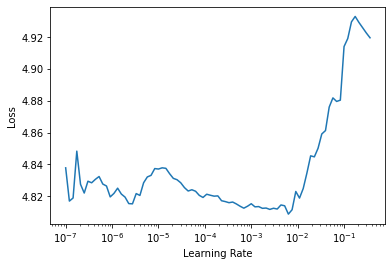

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

epoch,train_loss,valid_loss,loss_concat,loss_full,loss_crop1,loss_crop2,concat_accuracy,full_accuracy,crop1_accuracy,crop2_accuracy,time
0,4.717580,4.686374,4.665263,4.666717,4.686374,4.743415,0.034167,0.032500,0.020000,0.020000,01:56
1,4.330606,4.271115,4.536779,4.537497,4.271115,4.486353,0.051667,0.052500,0.059167,0.042500,01:55


In [64]:
lr /= 3 
learn.unfreeze()
learn.fit_one_cycle(int(epochs**2), lr_max=[lr, lr, lr, lr, lr], pct_start=0.5)

epoch,train_loss,valid_loss,loss_concat,loss_full,loss_crop1,loss_crop2,concat_accuracy,full_accuracy,crop1_accuracy,crop2_accuracy,time
0,12.755417,14.762497,2.594015,2.593076,4.787704,4.787704,0.450000,0.449167,0.008333,0.008333,03:26


KeyboardInterrupt: 

In [45]:
len(learn.collect_images.images)

180

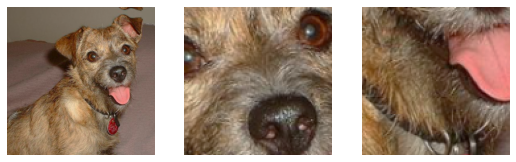

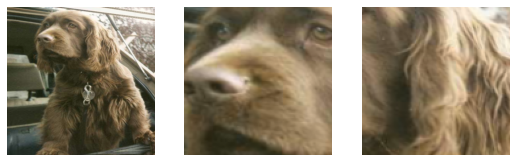

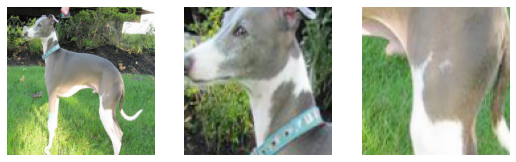

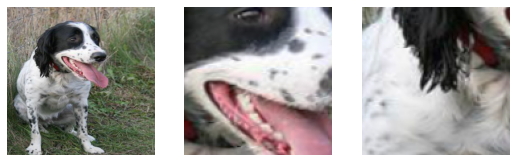

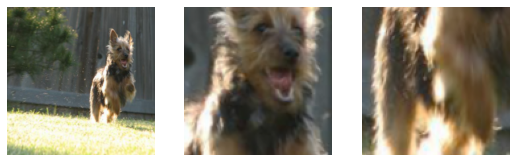

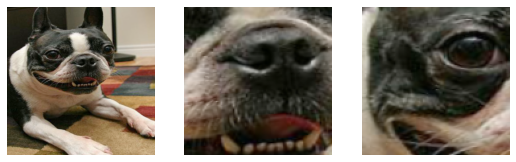

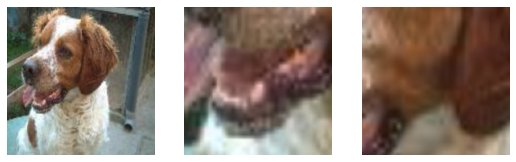

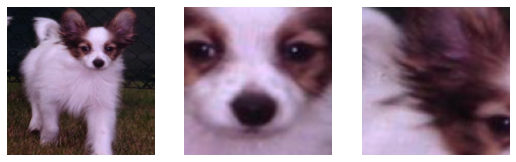

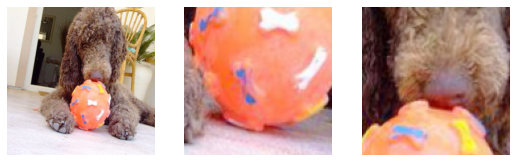

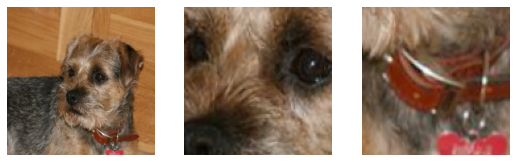

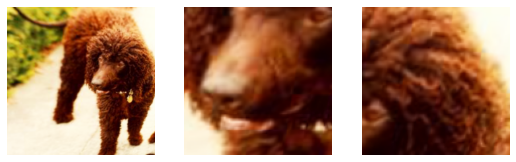

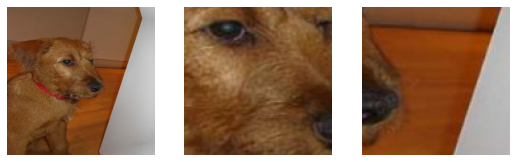

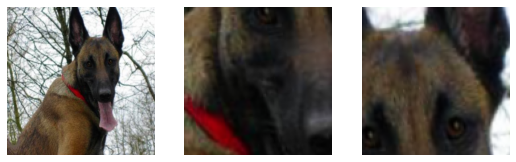

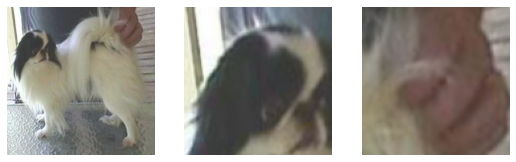

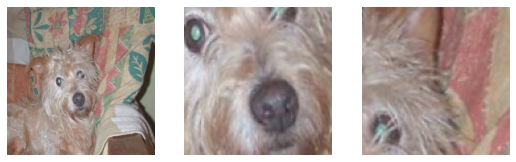

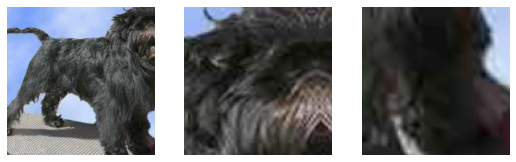

In [54]:
for images in learn.collect_images.images[16:32]:
    show_images([dls.after_batch.decode(o[None,...])[0] for o in images])